In [1]:
#%load ../init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import cosmo, utils, plot
from holodeck.constants import MSOL, PC, YR, MPC, GYR

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

# Quick Start

Construct a Semi-Analytic Model (SAM) using all of the default parameters

In [2]:
sam = holo.sam.Semi_Analytic_Model(shape=40)

In [6]:
hard = holo.hardening.Hard_GW()

Choose the edges of the frequency bins at which to calculate the GWB

In [7]:
fobs = utils.nyquist_freqs(10.0*YR, 0.2*YR)
fobs_edges = utils.nyquist_freqs_edges(10.0*YR, 0.2*YR)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 24
  between [0.10, 2.50] 1/yr
          [3.17, 79.22] nHz


Calculate GWB at given observed GW frequencies (`fobs`) for many different realizations to get a distribution of spectra

In [8]:
gwb = sam.gwb(fobs_edges, hard, realize=30)    # calculate many different realizations

16:44:08 INFO : Stalled SAM bins based on GMT: 2.56e+04/6.40e+04 = 4.00e-01 [sam.py:static_binary_density]
16:44:08 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
16:44:08 INFO : 	dens bef: (0.00e+00, 0.00e+00, 3.02e-67, 7.47e-04, 1.51e-02, 2.88e-02, 4.47e-02) [sam.py:static_binary_density]
16:44:09 INFO : Scatter added after 1.254063 sec [sam.py:static_binary_density]
16:44:09 INFO : 	dens aft: (3.80e-28, 7.16e-14, 2.29e-09, 1.02e-03, 1.54e-02, 2.89e-02, 4.26e-02) [sam.py:static_binary_density]
16:44:09 INFO : 	mass: 8.63e-02 ==> 8.62e-02 || change = -1.9166e-03 [sam.py:static_binary_density]
16:44:09 INFO : zeroing out 2.56e+04/6.40e+04 = 4.00e-01 systems stalled from GMT [sam.py:static_binary_density]


In [18]:
print(gwb[0].shape)
print(gwb[1].shape)

(25, 30, 1)
(25, 30)


Plot GWB over multiple realizations

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2, 25, 30) + inhomogeneous part.

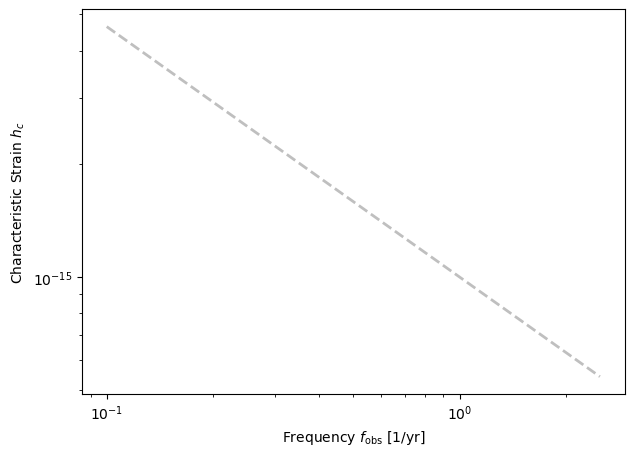

In [9]:
nsamp = 5    # number of sample GWB spectra to plot
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', ylabel='Characteristic Strain $h_c$')

# `fobs` are bin centers in CGS units, convert to [1/yr]
xx = fobs * YR

# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0)

# Plot the median GWB spectrum
ax.plot(xx, np.median(gwb, axis=-1), 'k-')

# Plot `nsamp` random spectra 
nsamp = np.min([nsamp, gwb.shape[1]])
idx = np.random.choice(gwb.shape[1], nsamp, replace=False)
ax.plot(xx, gwb[:, idx], 'k-', lw=1.0, alpha=0.1)

# plot contours at 50% and 98% confidence intervals
for pp in [50, 98]:
    percs = pp / 2
    percs = [50 - percs, 50 + percs]
    ax.fill_between(xx, *np.percentile(gwb, percs, axis=-1), alpha=0.25, color='b')
    
plt.show()

# build SAM component-by-component

Construct the four components required for all SAM models:

1) **Galaxy Stellar Mass Function (GSMF)**: number-density of galaxies as a function of stellar mass
2) **Galaxy Pair Fraction (GPF)**: fraction of galaxies that are in pairs
3) **Galaxy Merger Time (GMT)**: time it takes for galaxies to merge
4) **MBH––Galaxy Scaling Relationship (e.g. Mbh-Mbulge)**: mapping between galaxy properties (i.e. stellar mass) and BH mass

In [ ]:
gsmf = holo.sam.GSMF_Schechter()        # Galaxy Stellar-Mass Function (GSMF)
gpf = holo.sam.GPF_Power_Law()          # Galaxy Pair Fraction         (GPF)
gmt = holo.sam.GMT_Power_Law()          # Galaxy Merger Time           (GMT)
mmbulge = holo.relations.MMBulge_MM2013() # M-MBulge Relation            (MMB)

Build SAM using these components

In [ ]:
sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge, shape=40)

Calculate the distribution of GWB Amplitudes at 1/yr

In [ ]:
fobs_yr = 1.0/YR
fobs_yr = fobs_yr * (1.0 + np.array([-0.05, 0.05]))
ayr = sam.gwb(fobs_yr, realize=100).flatten()
gwb_ref = sam.gwb_ideal(1.0/YR)

Plot the distribution

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(ayr), density=True, confidence=True)
ax.axvline(np.log10(gwb_ref), ls='--', color='k')

plt.show()

## Plot GWB Amplitude Distribution vs. M-MBulge parameters

Calculate GWB amplitudes at $f = 1/yr$ over a grid of M-Mbulge parameters, specifically the amplitude and power-law.

In [ ]:
# Choose parameters to explore
NREALS = 30     # number of realizations at each parameter combination
alpha_list = [0.75, 1.0, 1.25, 1.5]     # M-Mbulge power-law index
norm_list = np.logspace(8, 9.5, 4)     # M-Mbulge normalization, units of [Msol]

dist_mmb = np.zeros((len(alpha_list), norm_list.size, NREALS))

# Iterate over a grid of both paremeters
for aa, alpha in enumerate(tqdm.tqdm(alpha_list)):
    for nn, norm in enumerate(tqdm.tqdm(norm_list, leave=False)):
        # Create the M-Mbulge relationship for these parameters
        mmbulge = holo.relations.MMBulge_Standard(mamp=norm*MSOL, mplaw=alpha)
        # Build a new sam
        sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge, shape=30)
        # Calculate the distribution of GWB amplitudes
        dist_mmb[aa, nn, :] = sam.gwb(fobs_yr, realize=NREALS)

Plot the interquartile ranges for each power-law, as a function of normalization

In [ ]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.set(xscale='log', xlabel='M-MBulge Mass Normalization', yscale='log', ylabel=r'GWB Amplitude $A_\mathrm{yr}$')
ax.grid(alpha=0.2)

for aa, dd in zip(alpha_list, dist_mmb):
    med = np.median(dd, axis=-1)
    cc, = ax.plot(norm_list, med, label=aa)
    cc = cc.get_color()
    ax.fill_between(norm_list, *np.percentile(dd, [25, 75], axis=-1), color=cc, alpha=0.15)
    
plt.legend(title='M-MBulge Slope')
plt.show()